# Regression
Regression is the act of predicting a real number (or continuous variable) from a set of features (represented as numbers).
There are several fundamental regression models in MLlib.
- Linear regression

- Generalized linear regression

- Isotonic regression

- Decision trees

- Random forest

- Gradient-boosted trees

- Survival regression

# Model Scalability
The regression models in MLlib all scale to large datasets.Below simple model scalability scorecard that will help you in choosing the best model for your particular task (if scalability is your core consideration). These will depend on your configuration, machine size, and other factors.
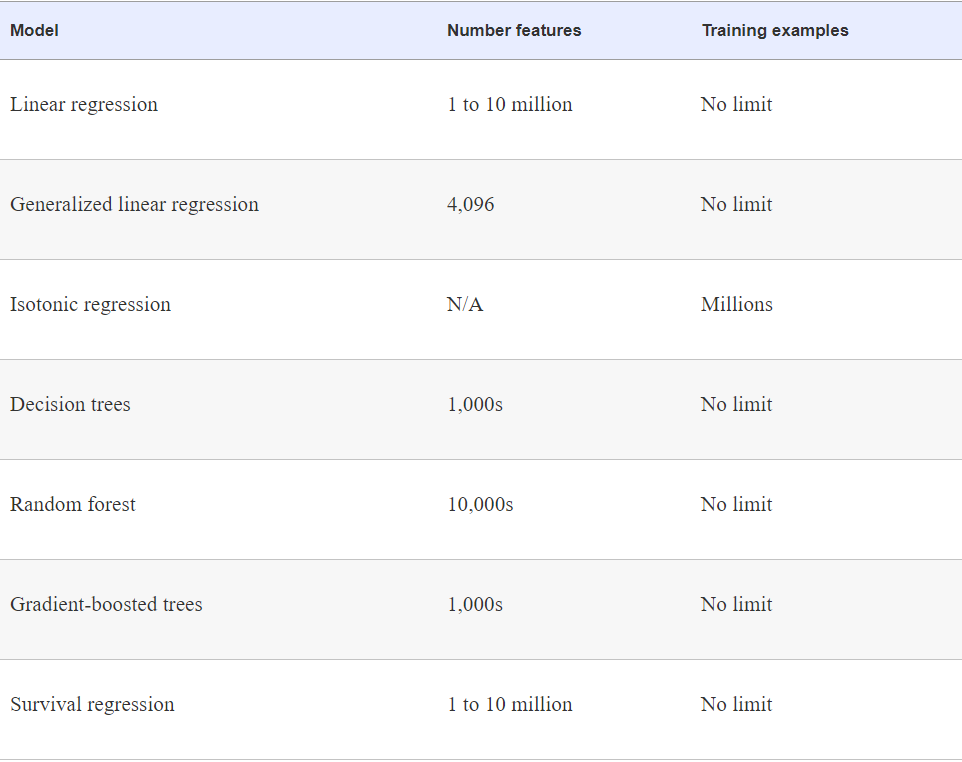

The learning objective is to minimize the specified loss function, with regularization. This supports two kinds of loss:

1. squaredError (a.k.a squared loss)
2. huber (a hybrid of squared error for relatively small errors and absolute error for relatively large ones, and we estimate the scale parameter from training data)

This supports multiple types of regularization:

- none (a.k.a. ordinary least squares)
- L2 (ridge regression)
- L1 (Lasso)
- L2 + L1 (elastic net)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("linear").getOrCreate()

In [2]:
df = spark.read.load("/common_folder/pyspark_data/regression")

Linear regression assumes that a linear combination of your input features (the sum of each feature multiplied by a weight) results along with an amount of Gaussian error in the output. This linear assumption (along with Gaussian error) does not always hold true, but it does make for a simple, interpretable model that’s hard to overfit. Like logistic regression, Spark implements ElasticNet regularization for this, allowing you to mix L1 and L2 regularization.

In [3]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression().setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)
print(lr.explainParams())
lrModel = lr.fit(df)


aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.8)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.3)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the tr

In [4]:
summary = lrModel.summary
summary.residuals.show()
print(summary.totalIterations)
print(summary.objectiveHistory)
print(summary.rootMeanSquaredError)
print(summary.r2)

+--------------------+
|           residuals|
+--------------------+
| 0.12805046585610147|
|-0.14468269261572053|
|-0.41903832622420595|
|-0.41903832622420595|
|  0.8547088792080308|
+--------------------+

6
[0.5000000000000001, 0.4315295810362787, 0.3132335933881022, 0.31225692666554117, 0.309150608198303, 0.30915058933480255]
0.47308424392175996
0.7202391226912209


The summary method returns a summary object with several fields. Let’s go through these in turn. The residuals are simply the weights for each of the features that we input into the model. The objective history shows how our training is going at every iteration. The root mean squared error is a measure of how well our line is fitting the data, determined by looking at the distance between each predicted value and the actual value in the data. The R-squared variable is a measure of the proportion of the variance of the predicted variable that is captured by the model.

# Generalized Linear Regression
The standard linear regression that we saw in this chapter is actually a part of a family of algorithms called generalized linear regression. Spark has two implementations of this algorithm. One is optimized for working with very large sets of features (the simple linear regression covered previously in this chapter), while the other is more general, includes support for more algorithms, and doesn’t currently scale to large numbers of features.

The generalized form of linear regression gives you more fine-grained control over what kind of regression model you use. For instance, these allow you to select the expected noise distribution from a variety of families, including Gaussian (linear regression), binomial (logistic regression), poisson (poisson regression), and gamma (gamma regression). The generalized models also support setting a link function that specifies the relationship between the linear predictor and the mean of the distribution function
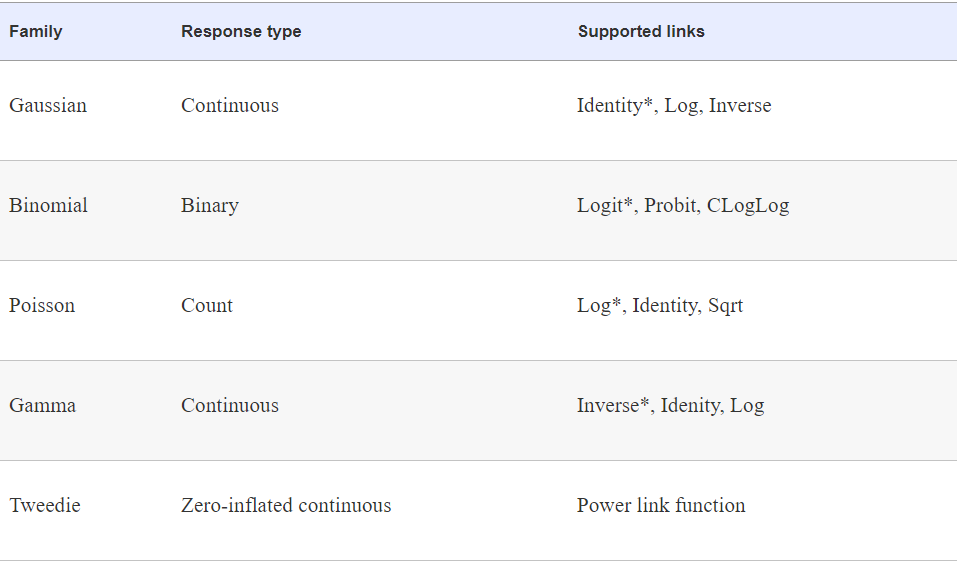

In [5]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression()\
  .setFamily("gaussian")\
  .setLink("identity")\
  .setMaxIter(10)\
  .setRegParam(0.3)\
  .setLinkPredictionCol("linkOut")
print(glr.explainParams())
glrModel = glr.fit(df)

family: The name of family which is a description of the error distribution to be used in the model. Supported options: gaussian (default), binomial, poisson, gamma and tweedie. (default: gaussian, current: gaussian)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
link: The name of link function which provides the relationship between the linear predictor and the mean of the distribution function. Supported options: identity, log, inverse, logit, probit, cloglog and sqrt. (current: identity)
linkPower: The index in the power link function. Only applicable to the Tweedie family. (undefined)
linkPredictionCol: link prediction (linear predictor) column name (current: linkOut)
maxIter: max number of iterations (>= 0). (default: 25, current: 10)
offsetCol: The offset column name. If this is not set or empty, we treat all instance offsets as 0.0 (undefined)
predictionCol: pred

In [6]:
from pyspark.ml.regression import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
print(dtr.explainParams())
dtrModel = dtr.fit(df)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. 

In [7]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
rf =  RandomForestRegressor()
print(rf.explainParams())
rfModel = rf.fit(df)
gbt = GBTRegressor()
print(gbt.explainParams())
gbtModel = gbt.fit(df)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

# Evaluators and Automating Model Tuning
Regression has the same core model tuning functionality that we saw with classification. We can specify an evaluator, pick a metric to optimize for, and then train our pipeline to perform that parameter tuning on our part. The evaluator for regression, unsurprisingly, is called the RegressionEvaluator and allows us to optimize for a number of common regression success metrics. Just like the classification evaluator, RegressionEvaluator expects two columns, a column representing the prediction and another representing the true label. The supported metrics to optimize for are the root mean squared error (“rmse”), the mean squared error (“mse”), the r2 metric (“r2”), and the mean absolute error (“mae”).

To use RegressionEvaluator, we build up our pipeline, specify the parameters we would like to test, and then run it. Spark will automatically select the model that performs best and return this to us:

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
glr = GeneralizedLinearRegression().setFamily("gaussian").setLink("identity")
pipeline = Pipeline().setStages([glr])
params = ParamGridBuilder().addGrid(glr.regParam, [0, 0.5, 1]).build()
evaluator = RegressionEvaluator()\
  .setMetricName("rmse")\
  .setPredictionCol("prediction")\
  .setLabelCol("label")
cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(params)\
  .setNumFolds(2) # should always be 3 or more but this dataset is small
model = cv.fit(df)

# Metrics
Evaluators allow us to evaluate and fit a model according to one specific metric, but we can also access a number of regression metrics via the RegressionMetrics object. As for the classification metrics in the previous chapter, RegressionMetrics operates on RDDs of (prediction, label) pairs. For instance, let’s see how we can inspect the results of the previously trained model.

In [9]:
from pyspark.mllib.evaluation import RegressionMetrics
out = model.transform(df)\
  .select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = RegressionMetrics(out)
print("MSE: " + str(metrics.meanSquaredError))
print("RMSE: " + str(metrics.rootMeanSquaredError))
print("R-squared: " + str(metrics.r2))
print("MAE: " + str(metrics.meanAbsoluteError))
print("Explained variance: " + str(metrics.explainedVariance))


MSE: 0.21432448963739992
RMSE: 0.4629519301584128
R-squared: 0.7320943879532501
MAE: 0.34692281471051284
Explained variance: 0.3292344702110489
